## 1. Import Dependencies

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Instantiate Model

In [2]:
## Sentiment Model
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
# Model
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

## Zero Shot Classifier
# Model
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

## 3. Load in Reviews and EDA

### 3.1 Load in Review Data

In [3]:
df_qts = pd.read_csv('/kaggle/input/tripadvisorreviews/qantas_data.csv').drop('Unnamed: 0',axis=1)
df_sa = pd.read_csv('/kaggle/input/tripadvisorreviews/singapore_data.csv').drop('Unnamed: 0',axis=1)
df_qts['review'] = df_qts['review'].apply(lambda x: x.replace("\'", ""))
df_sa['review'] = df_sa['review'].apply(lambda x: x.replace("\'", ""))
df_qts['airline'] = 'qantas'
df_sa['airline'] = 'singapore'

In [4]:
df = pd.concat([df_qts,df_sa]).reset_index().drop(columns='index')

### 3.2 Complete high level analysis of ratings

In [5]:
print(f'For Qantas, we have {df_qts.shape[0]} reviews and for Singapore Airlines we have {df_sa.shape[0]} reviews')

For Qantas, we have 1005 reviews and for Singapore Airlines we have 1005 reviews


<AxesSubplot:xlabel='class', ylabel='count'>

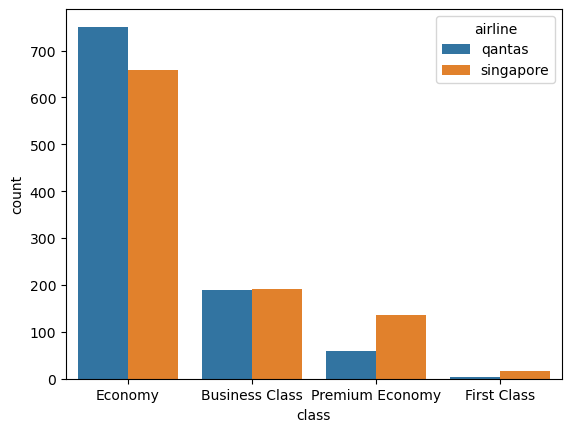

In [6]:
sns.countplot(df,x='class',hue='airline')

In [7]:
print(f'Average rating for Singapore is {df_sa["rating"].mean()} & the average rating for Qantas is {df_qts["rating"].mean()}')

Average rating for Singapore is 26.16915422885572 & the average rating for Qantas is 20.437810945273633


<AxesSubplot:xlabel='class', ylabel='count'>

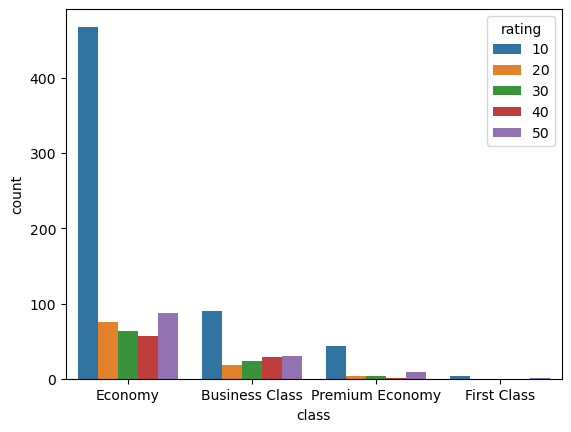

In [8]:
sns.countplot(df_qts,x='class',hue='rating')

<AxesSubplot:xlabel='class', ylabel='count'>

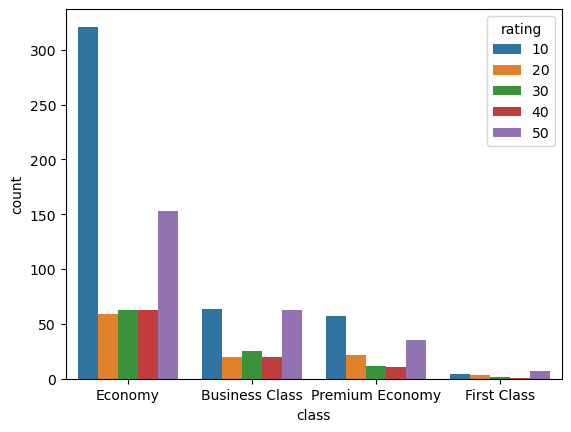

In [9]:
sns.countplot(df_sa,x='class',hue='rating')

<AxesSubplot:xlabel='class', ylabel='rating'>

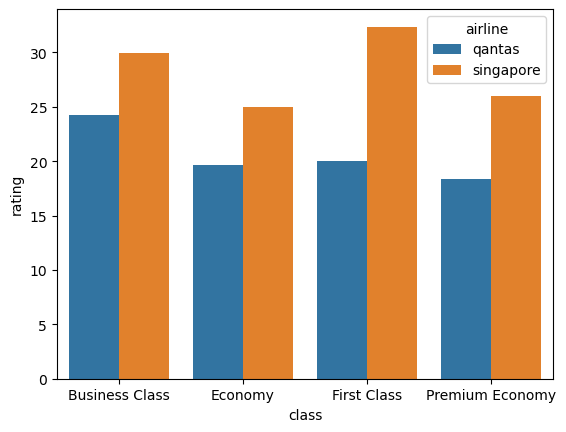

In [10]:
sns.barplot(df.groupby(['airline','class']).agg({"rating":"mean"}).reset_index(),x='class',y='rating',hue='airline')

### 3.3 Analysis of Reviews

In [11]:
text_qts = " ".join(review for review in df_qts.loc[df_qts['rating']<30].review)
text_sa = " ".join(review for review in df_sa.loc[df_sa['rating']<30].review)

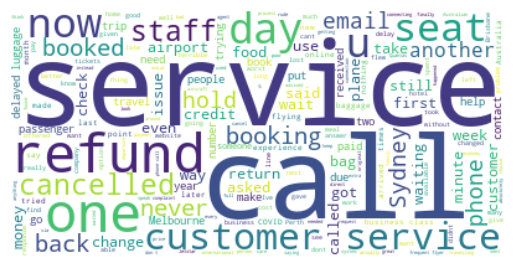

In [12]:
from wordcloud import WordCloud, STOPWORDS
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['flight','Qantas','Singapore','Airline','flights','airlines','will','ticket','told','fly', 'hour','hours','time'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_qts)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

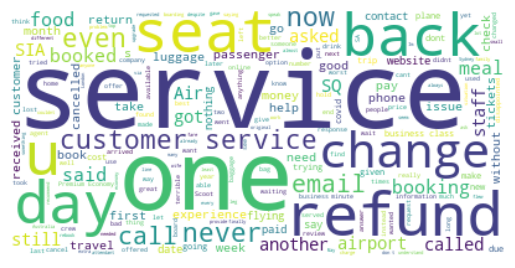

In [13]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_sa)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The biggest categories for bad reviews are:
- Service
- Seat/Comfort
- Refund
- Food
- Call (Customer service)
- Cancellation
- Cost/Money

All of these categories should be added to the zero shot classifier. In addition, the following could be added:
- Delays
- Communication

## 4. Create functions

In [14]:
# Create review sentiment function
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits)) + 1

In [15]:
# Create review classification function
candidate_labels = ['service','comfort','refund','food','communication','cancellation','cost','delays']
df[candidate_labels] = 0
def classification(review, index):
    sequence_to_classify = review
    result = classifier(sequence_to_classify, candidate_labels, multi_label = True)
    labels, scores = result['labels'], result['scores']
    for label, score in zip(labels, scores):
        df.loc[index, label] = score

## 5. Complete Sentiment Analysis of Reviews

In [16]:
df['sentiment'] = df['review'].apply(lambda x: sentiment_score(x[:512]))

In [17]:
df['sentiment_transformed'] = df['sentiment'].apply(lambda x: x*10)

In [18]:
df['sentiment_similarity'] = df.apply(lambda x: np.abs(x.rating - x.sentiment_transformed),axis=1)

## 6. Complete Classification of reviews

In [19]:
from tqdm import tqdm

In [20]:
for index, i in zip(df.index, tqdm(range(df.shape[0]),desc='Loading')):
        classification(df.loc[index,'review'],index)

Loading: 100%|█████████▉| 2009/2010 [6:26:46<00:11, 11.55s/it]   


In [21]:
df.to_csv('df_final.csv')